在前一个猫狗分类网络里，过拟合很快产生，下面将使用一些技术来处理这个问题。

In [1]:
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt

首先增加一个 `Dropout` 层。

In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

2023-10-01 22:36:13.294346: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-01 22:36:13.294377: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-01 22:36:13.294384: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-01 22:36:13.294420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-01 22:36:13.294443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [3]:
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

然后对图片进行增量化处理，主要是为了在有限的数据里产生更多的数据，keras 提供了一些基本工具来达到这个目的。比如将图片平移一下，旋转一下，或者翻转一下。通过这个方式可以基于原本的数据集产生更多类似的，但是新的数据。下面是一个例子。

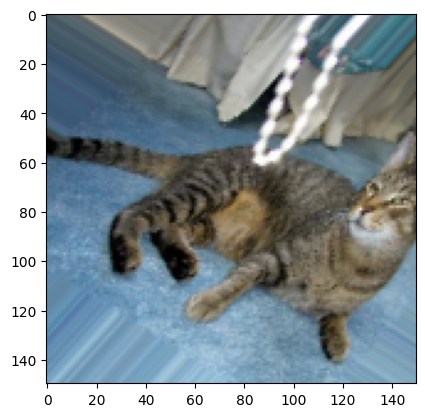

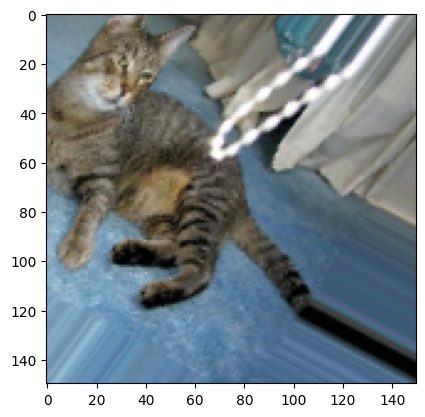

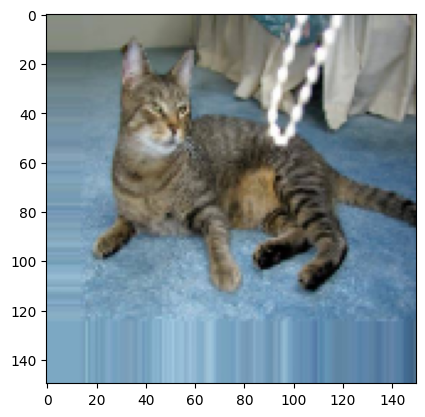

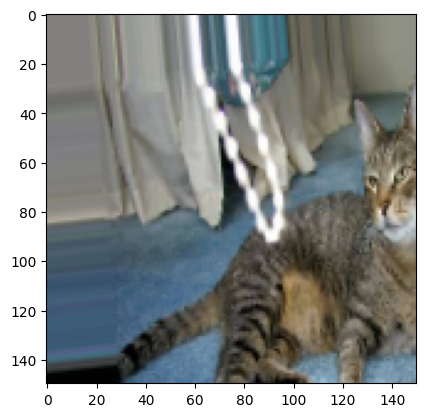

In [4]:
import os
from keras.preprocessing import image

datagen = image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_cats_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train/cats'

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# choose one image
img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
# reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train'
validation_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/validation'
test_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
# !!! The validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/150


/var/folders/63/hmm24s352qv_4vs09n66p97m0000gn/T/ipykernel_72367/1931940295.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-10-01 22:36:57.469011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 12s 85ms/step - loss: 0.8505 - accuracy: 0.5070 - val_loss: 0.6877 - val_accuracy: 0.5520
Epoch 2/150
100/100 [==============================] - 8s 82ms/step - loss: 0.6966 - accuracy: 0.5215 - val_loss: 0.6742 - val_accuracy: 0.5620
Epoch 3/150
100/100 [==============================] - 8s 81ms/step - loss: 0.6892 - accuracy: 0.5515 - val_loss: 1.3700 - val_accuracy: 0.5110
Epoch 4/150
100/100 [==============================] - 9s 85ms/step - loss: 0.6828 - accuracy: 0.5620 - val_loss: 0.6727 - val_accuracy: 0.5770
Epoch 5/150
100/100 [==============================] - 8s 83ms/step - loss: 0.6764 - accuracy: 0.5615 - val_loss: 0.6491 - val_accuracy: 0.6150
Epoch 6/150
100/100 [==============================] - 8s 79ms/step - loss: 0.6805 - accuracy: 0.5895 - val_loss: 0.6152 - val_accuracy: 0.6620
Epoch 7/150
100/100 [==============================] - 8s 79ms/step - loss: 0.6584 - accuracy: 0.6030 - val_loss: 0.6278 - val_accuracy: 0.6320
Epo

In [8]:
model.save('/Users/bifnudozhao/Projects/ai-playground/results/cats_and_dogs_small_augmentation.keras')
tf.keras.saving.save_model(
    model,
    '/Users/bifnudozhao/Projects/ai-playground/results/cats_and_dogs_small_augmentation.h5',
    save_format='h5'
    )

/var/folders/63/hmm24s352qv_4vs09n66p97m0000gn/T/ipykernel_72367/1390912784.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.saving.save_model(


In [13]:
import matplotlib.pyplot as plt

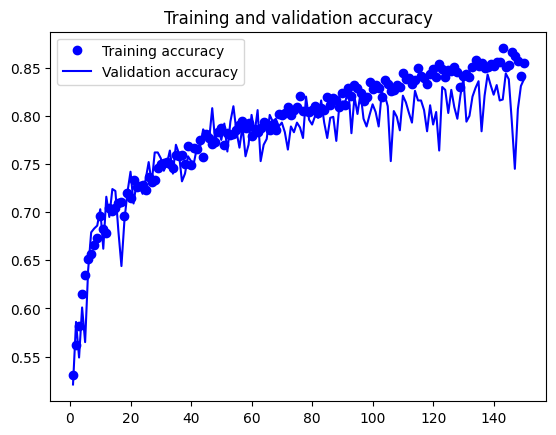

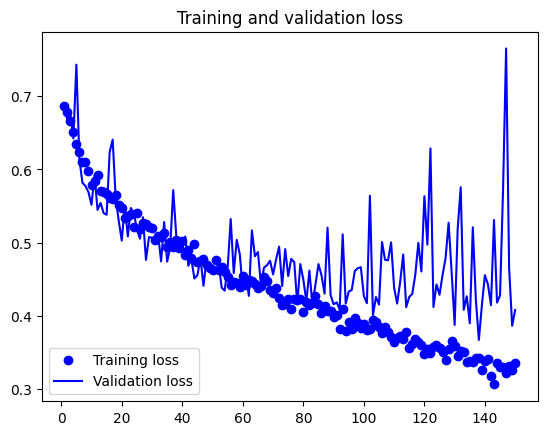

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上图可以看出，这是典型的过拟合。训练数据的正确率一直在上升，误差一直在下降，但是验证数据的正确率就只停在了 70% 左右，而误差也在上升。